<a href="https://colab.research.google.com/github/sashank1326/ML_Practice/blob/main/Titanic_Ml_Features.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import chi2, f_classif
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

In [18]:
df = pd.read_csv("/content/drive/MyDrive/ML_LAB/titanic_train.csv")

df.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


In [19]:
df.isnull().sum()

,0
PassengerId,0
Survived,0
Pclass,0
Name,0
Sex,0
Age,177
SibSp,0
Parch,0
Ticket,0
Fare,0


In [20]:
df.dropna(axis = 1,thresh= 0.7*len(df),inplace = True)

# Filling the null values(numeric column) with median

numerical_cols = df.select_dtypes(include = ['int64','float64']).columns
categorical_cols = df.select_dtypes(include = ['int64','float64']).columns

df[numerical_cols] = df[numerical_cols].fillna(df[numerical_cols].mean())

for col in categorical_cols:
    df[col] = df[col].fillna(df[col].mode()[0])

In [21]:
X = df.drop("Survived", axis=1)
y = df["Survived"]


# 2. Split train and test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)

Train shape: (712, 10)
Test shape: (179, 10)


In [22]:
constant_features = [col for col in X_train.columns if X_train[col].nunique() == 1]

print(constant_features)

[]


In [23]:
# 4. Quasi-constant features (based on threshold)
quasi_constant_features = []
threshold = 0.95

for col in X_train.columns:
    freq = X_train[col].value_counts(normalize=True).values[0]
    if freq >= threshold:
        quasi_constant_features.append(col)

print("Quasi-constant features:", quasi_constant_features)

X_train.drop(columns=quasi_constant_features, inplace=True)
X_test.drop(columns=quasi_constant_features, inplace=True)

Quasi-constant features: []


In [24]:
duplicated_features = []
cols = X_train.columns

for i in range(len(cols)):
    for j in range(i + 1, len(cols)):
        if X_train[cols[i]].equals(X_train[cols[j]]):
            duplicated_features.append(cols[j])

print(duplicated_features)

[]


In [25]:
numeric_X_train = X_train.select_dtypes(include=['number'])

corr_matrix = numeric_X_train.corr()
corr_threshold = 0.98
corr_pairs = set()

# Find highly correlated features
for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if abs(corr_matrix.iloc[i, j]) > corr_threshold:
            corr_pairs.add(corr_matrix.columns[i])

print("Highly Correlated Features:", corr_pairs)

Highly Correlated Features: set()


[]

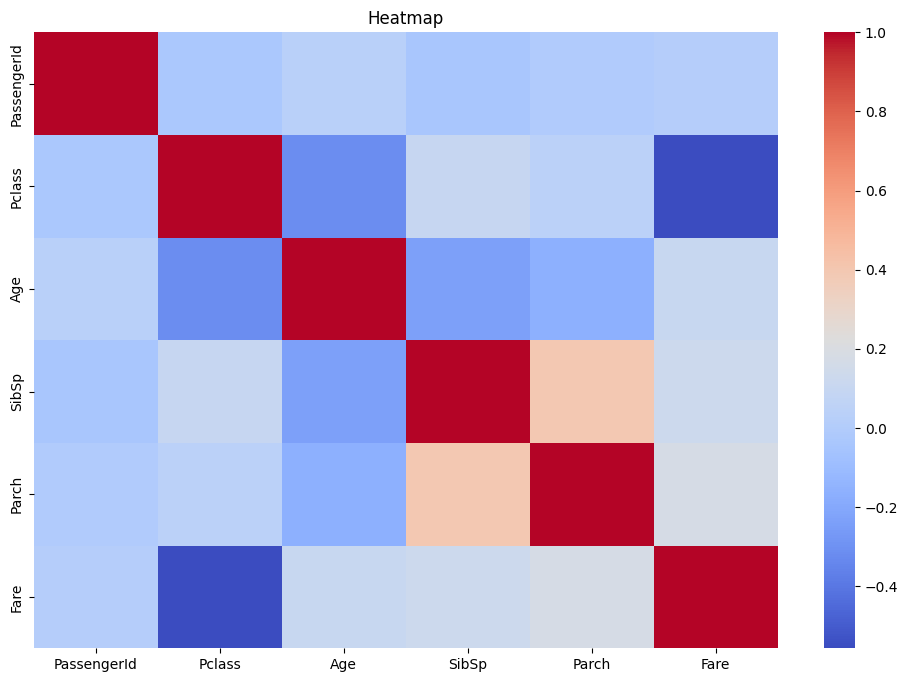

In [26]:
plt.figure(figsize = (12,8))
sns.heatmap(corr_matrix,annot=False,cmap = "coolwarm")
plt.title("Heatmap")
plt.plot()

In [27]:
from sklearn.feature_selection import mutual_info_regression
import pandas as pd

# Select numeric features
numeric_X_train = X_train.select_dtypes(include=['number'])

# Compute MI scores
mi_scores = mutual_info_regression(numeric_X_train, y_train, discrete_features=False)

# Create DataFrame of results
mi_df = pd.DataFrame({
    "Features": numeric_X_train.columns,
    "MI Score": mi_scores
}).sort_values(by="MI Score", ascending=False)

# Select features with MI score < 0.01
# print(mi_df)
low_imp = mi_df[mi_df["MI Score"] < 0.01]["Features"].tolist()

print("Low Importance Features:", low_imp)

# Drop low importance features
X_train = X_train.drop(columns=low_imp)
X_test = X_test.drop(columns=low_imp)

Low Importance Features: ['Parch', 'PassengerId']


In [28]:
cat_features = X_train.select_dtypes(include=['object', 'category']).copy()

# Encode categorical features numerically
label_enc = LabelEncoder()
for col in cat_features.columns:
    cat_features[col] = cat_features[col].astype(str)  # Handle NaN as string
    cat_features[col] = label_enc.fit_transform(cat_features[col])

# Apply Chi-square test
chi_scores, p_values_chi = chi2(cat_features, y_train)

chi_df = pd.DataFrame({
    'Feature': cat_features.columns,
    'Chi2_Score': chi_scores,
    'P_Value': p_values_chi
}).sort_values(by='Chi2_Score', ascending=False)

print("Chi-Square Test Results (Categorical Features):")
print(chi_df)

Chi-Square Test Results (Categorical Features):
    Feature   Chi2_Score       P_Value
2    Ticket  2058.884368  0.000000e+00
0      Name   360.798816  1.886447e-80
1       Sex    76.301994  2.434380e-18
3  Embarked    10.099757  1.482889e-03


In [29]:
num_features = X_train.select_dtypes(include=['int64', 'float64']).copy()

# Scale features (optional for ANOVA stability)
scaler = MinMaxScaler()
num_scaled = scaler.fit_transform(num_features)

# Apply ANOVA F-test for classification
f_scores, p_values_anova = f_classif(num_scaled, y_train)

anova_df = pd.DataFrame({
    'Feature': num_features.columns,
    'F_Score': f_scores,
    'P_Value': p_values_anova
}).sort_values(by='F_Score', ascending=False)

print("\nANOVA Test Results (Numeric Features):")
print(anova_df)


ANOVA Test Results (Numeric Features):
  Feature    F_Score       P_Value
0  Pclass  97.835853  1.064770e-21
3    Fare  58.314907  7.230704e-14
1     Age   4.142223  4.219711e-02
2   SibSp   0.484537  4.866020e-01
